In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_folder_path = '/content/drive/'


Mounted at /content/drive


In [3]:
# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/dataset/GNN_Dataset/patientdata.csv")  # Replace with the actual file path

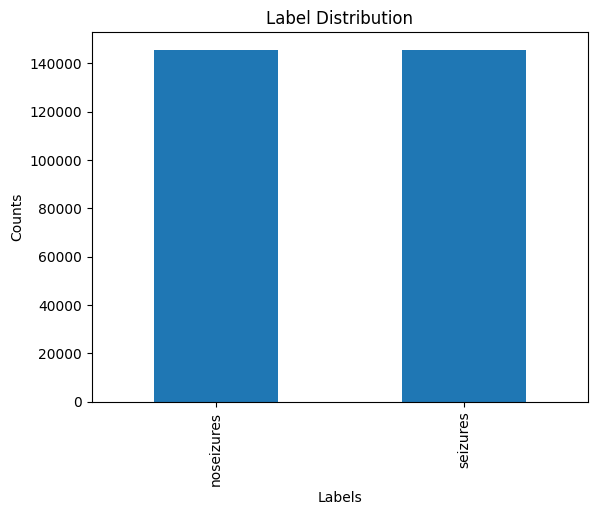

In [4]:
# Visualize the label column
label_counts = data['label_class'].value_counts()
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Label Distribution')
plt.show()

In [5]:
# Separate features and labels
X = data.drop("label_class", axis=1)
y = data["label_class"]

In [6]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [7]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [8]:
# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Convert the data to TensorFlow tensors
X_train_tensor = tf.constant(X_train_scaled, dtype=tf.float32)
y_train_tensor = tf.constant(y_train, dtype=tf.int32)
X_test_tensor = tf.constant(X_test_scaled, dtype=tf.float32)
y_test_tensor = tf.constant(y_test, dtype=tf.int32)

In [21]:
import tensorflow as tf

class SimpleRNNModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(SimpleRNNModel, self).__init__()
        self.rnn_layer = tf.keras.layers.SimpleRNN(32, activation='relu')
        self.dense_output = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, axis=-1)
        x = self.rnn_layer(expanded_inputs)
        output = self.dense_output(x)
        return output

In [22]:
num_classes = len(label_encoder.classes_)
model = SimpleRNNModel(num_classes)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
epochs = 10
batch_size = 32
steps_per_epoch = len(X_train_scaled) // batch_size
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        start = step * batch_size
        end = (step + 1) * batch_size
        with tf.GradientTape() as tape:
            predictions = model(X_train_tensor[start:end])
            loss = loss_object(y_train_tensor[start:end], predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss = loss_object(y_train_tensor, model(X_train_tensor))
    test_loss = loss_object(y_test_tensor, model(X_test_tensor))
    train_loss_history.append(train_loss.numpy())
    test_loss_history.append(test_loss.numpy())

    y_pred_train = np.argmax(model(X_train_tensor).numpy(), axis=1)
    y_pred_test = np.argmax(model(X_test_tensor).numpy(), axis=1)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10, Train Loss: 0.3483, Train Accuracy: 0.8511, Test Loss: 0.3510, Test Accuracy: 0.8488
Epoch 2/10, Train Loss: 0.3393, Train Accuracy: 0.8561, Test Loss: 0.3424, Test Accuracy: 0.8543
Epoch 3/10, Train Loss: 0.3394, Train Accuracy: 0.8545, Test Loss: 0.3412, Test Accuracy: 0.8532
Epoch 4/10, Train Loss: 0.3347, Train Accuracy: 0.8568, Test Loss: 0.3383, Test Accuracy: 0.8556
Epoch 5/10, Train Loss: 0.3233, Train Accuracy: 0.8642, Test Loss: 0.3274, Test Accuracy: 0.8630
Epoch 6/10, Train Loss: 0.3135, Train Accuracy: 0.8717, Test Loss: 0.3187, Test Accuracy: 0.8708
Epoch 7/10, Train Loss: 0.3223, Train Accuracy: 0.8644, Test Loss: 0.3269, Test Accuracy: 0.8625
Epoch 8/10, Train Loss: 0.3191, Train Accuracy: 0.8670, Test Loss: 0.3243, Test Accuracy: 0.8659
Epoch 9/10, Train Loss: 0.3141, Train Accuracy: 0.8699, Test Loss: 0.3206, Test Accuracy: 0.8673
Epoch 10/10, Train Loss: 0.3093, Train Accuracy: 0.8724, Test Loss: 0.3154, Test Accuracy: 0.8700


In [23]:
# Evaluation
y_pred_train_prob = model(X_train_tensor).numpy()
y_pred_test_prob = model(X_test_tensor).numpy()

# Convert probabilities to class indices
y_pred_train = np.argmax(y_pred_train_prob, axis=1)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)


In [24]:
# F1 Score
f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

# Accuracy
train_accuracy = np.mean(np.equal(y_train, y_pred_train))
test_accuracy = np.mean(np.equal(y_test, y_pred_test))

# Other metrics
print("Train F1 Score:", f1_train)
print("Test F1 Score:", f1_test)

# Accuracy
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train F1 Score: 0.8724374303546774
Test F1 Score: 0.8699736081982974
Train Accuracy: 0.8724459585861273
Test Accuracy: 0.8699927916795387


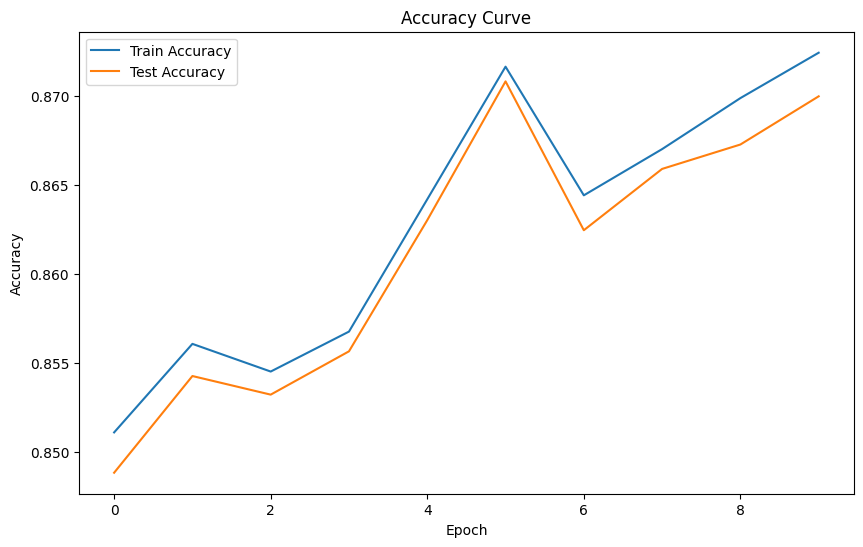

In [25]:
# Confusion Matrix
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# Plot Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_accuracy_history, label='Train Accuracy')
plt.plot(range(epochs), test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

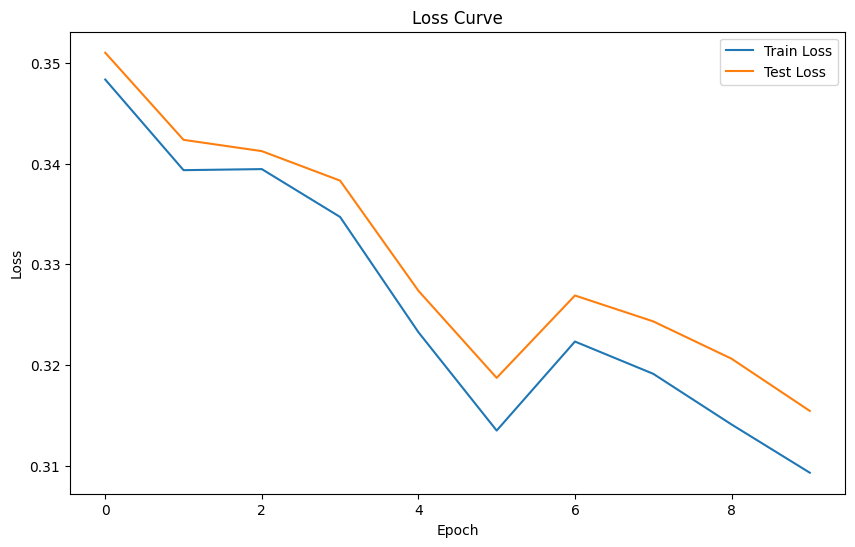

In [26]:
# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [27]:
# Classification Report
report_train = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)
report_test = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_)

In [28]:
# Print Confusion Matrix and Classification Report
print("Train Classification Report:")
print(report_train)

Train Classification Report:
              precision    recall  f1-score   support

  noseizures       0.88      0.86      0.87    116674
    seizures       0.87      0.88      0.87    116388

    accuracy                           0.87    233062
   macro avg       0.87      0.87      0.87    233062
weighted avg       0.87      0.87      0.87    233062



In [29]:
print("Test Classification Report:")
print(report_test)

Test Classification Report:
              precision    recall  f1-score   support

  noseizures       0.88      0.86      0.87     28990
    seizures       0.86      0.88      0.87     29276

    accuracy                           0.87     58266
   macro avg       0.87      0.87      0.87     58266
weighted avg       0.87      0.87      0.87     58266



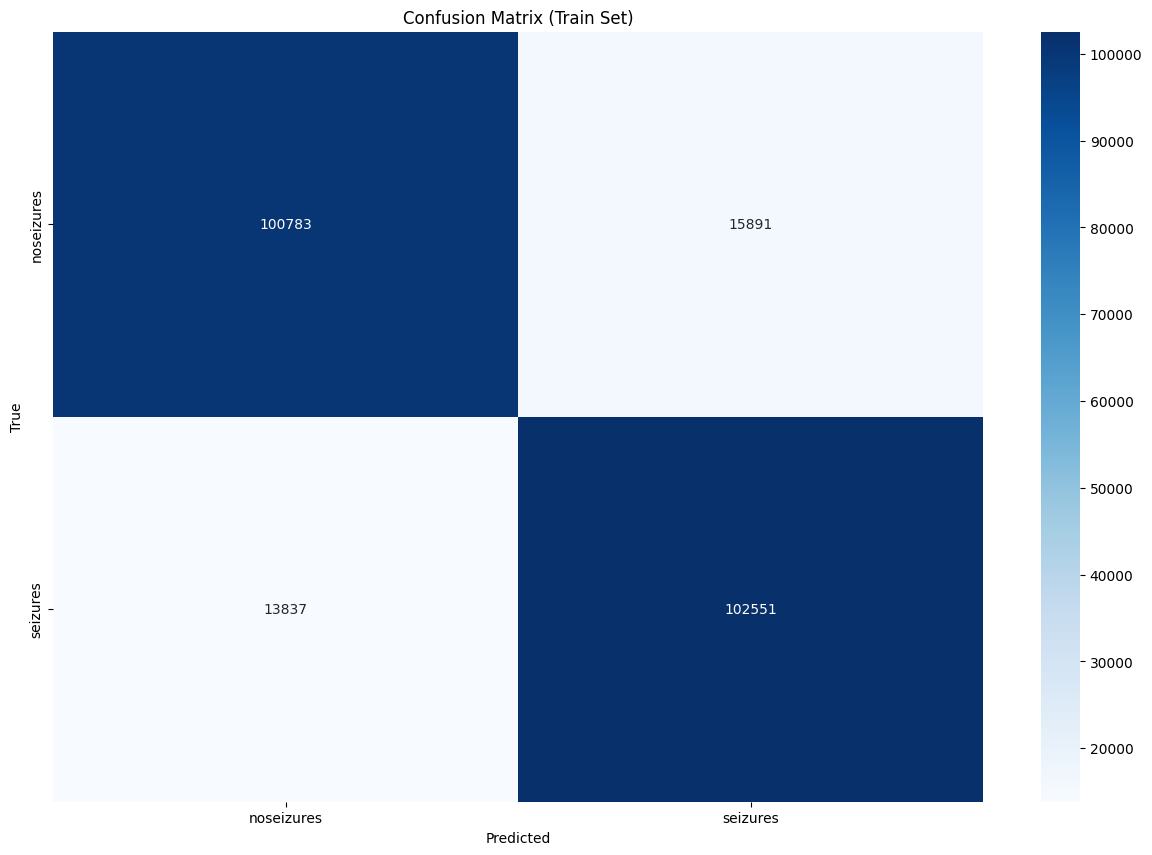

In [30]:
# Plot Confusion Matrix Heatmap for Train Set
plt.figure(figsize=(15, 10))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Train Set)')
plt.show()

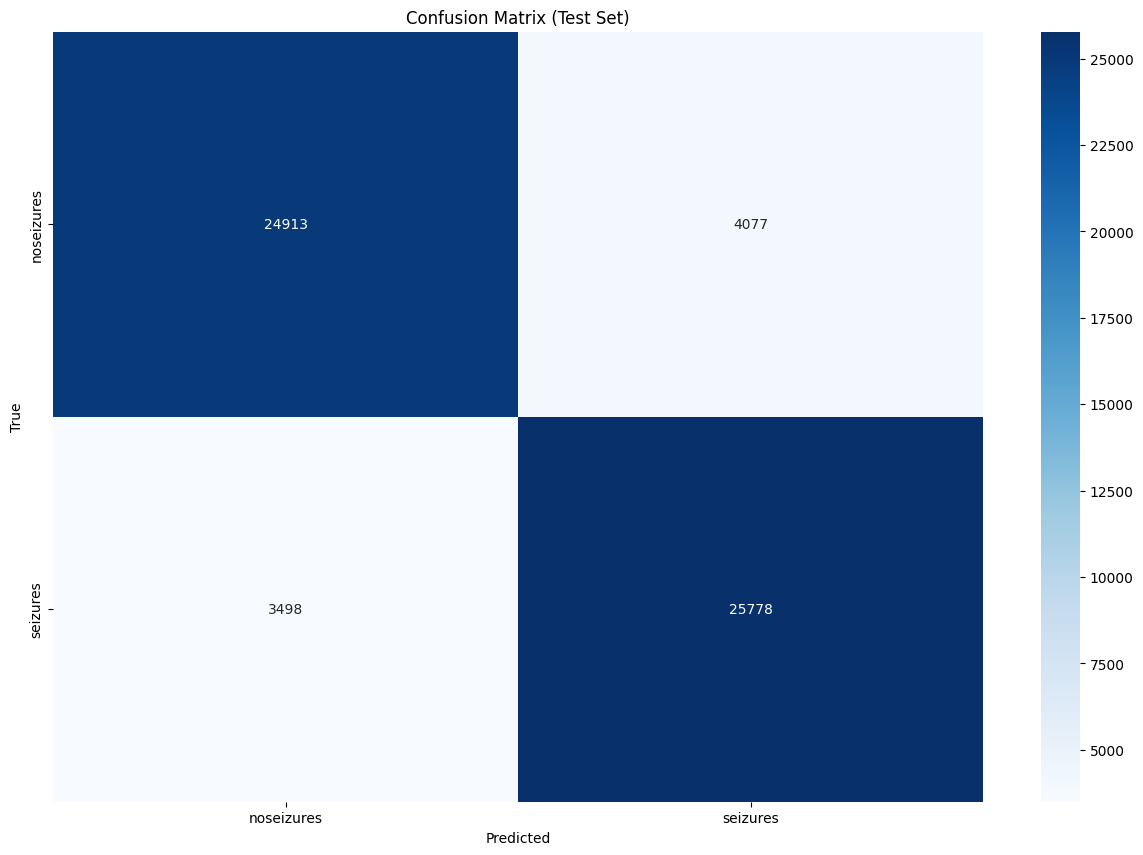

In [31]:
# Plot Confusion Matrix Heatmap for Test Set
plt.figure(figsize=(15, 10))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

In [32]:
print(y_train.shape)


(233062,)


ROC AUC Train: 0.9403517530706061
ROC AUC Test: 0.9385001325657004


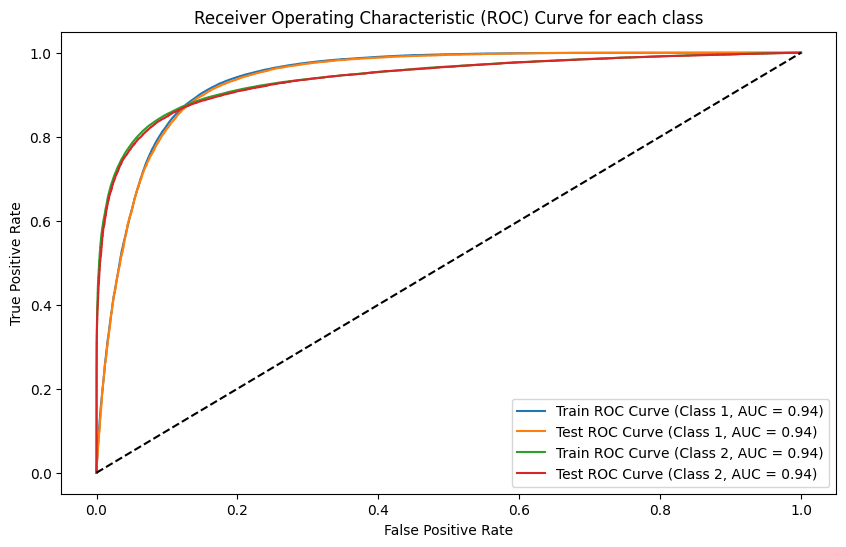

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

# Assuming y_pred_train_prob and y_pred_test_prob are the predicted probabilities for each class
# Extract the probabilities for each class
y_pred_train_prob = model(X_train_tensor).numpy()
y_pred_test_prob = model(X_test_tensor).numpy()

# Convert probabilities to class indices
y_pred_train = np.argmax(y_pred_train_prob, axis=1)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

# Calculate ROC AUC score for each class
roc_auc_train = []
roc_auc_test = []

for i in range(num_classes):  # Replace num_classes with the actual number of classes
    roc_auc_train.append(roc_auc_score(y_train == i, y_pred_train_prob[:, i]))
    roc_auc_test.append(roc_auc_score(y_test == i, y_pred_test_prob[:, i]))

# Print or use roc_auc_train and roc_auc_test as needed
print("ROC AUC Train:", np.mean(roc_auc_train))
print("ROC AUC Test:", np.mean(roc_auc_test))

# Plot ROC curves
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr_train, tpr_train, _ = roc_curve(y_train == i, y_pred_train_prob[:, i])
    roc_auc_train_class = auc(fpr_train, tpr_train)
    plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (Class {i + 1}, AUC = {roc_auc_train_class:.2f})')

    fpr_test, tpr_test, _ = roc_curve(y_test == i, y_pred_test_prob[:, i])
    roc_auc_test_class = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (Class {i + 1}, AUC = {roc_auc_test_class:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
plt.legend()
plt.show()
